In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import pystan
pd.set_option("display.max_rows", 101)
pd.set_option("display.max_columns", 101)
%matplotlib inline

In [57]:
#データ読み込み
data=pd.read_csv("../input/atp_matches_2018.csv",encoding='latin-1')

In [58]:
data.head()

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,winner_name,winner_hand,winner_ht,winner_ioc,winner_age,winner_rank,winner_rank_points,loser_id,loser_seed,loser_entry,loser_name,loser_hand,loser_ht,loser_ioc,loser_age,loser_rank,loser_rank_points,score,best_of,round,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced
0,2018-M020,Brisbane,Hard,32,A,20180101,300,106401,3.0,NaN,Nick Kyrgios,R,193.0,AUS,22.683094,21.0,2010.0,105992,NaN,NaN,Ryan Harrison,R,183.0,USA,25.653662,47.0,1010.0,6-4 6-2,3,F,73.0,17.0,1.0,56.0,40.0,33.0,9.0,9.0,5.0,5.0,8.0,3.0,58.0,32.0,22.0,12.0,9.0,4.0,7.0
1,2018-M020,Brisbane,Hard,32,A,20180101,299,106401,3.0,NaN,Nick Kyrgios,R,193.0,AUS,22.683094,21.0,2010.0,105777,1.0,NaN,Grigor Dimitrov,R,188.0,BUL,26.631075,3.0,5150.0,3-6 6-1 6-4,3,SF,93.0,19.0,2.0,72.0,50.0,41.0,11.0,13.0,1.0,2.0,5.0,6.0,74.0,44.0,32.0,16.0,13.0,3.0,6.0
2,2018-M020,Brisbane,Hard,32,A,20180101,298,105992,NaN,NaN,Ryan Harrison,R,183.0,USA,25.653662,47.0,1010.0,200282,NaN,WC,Alex De Minaur,R,NaN,AUS,18.872005,208.0,245.0,4-6 7-6(5) 6-4,3,SF,157.0,14.0,5.0,115.0,70.0,49.0,24.0,16.0,3.0,6.0,9.0,5.0,94.0,62.0,49.0,16.0,16.0,0.0,3.0
3,2018-M020,Brisbane,Hard,32,A,20180101,297,105777,1.0,NaN,Grigor Dimitrov,R,188.0,BUL,26.631075,3.0,5150.0,106378,NaN,NaN,Kyle Edmund,R,NaN,GBR,22.981520,50.0,992.0,6-3 6-7(3) 6-4,3,QF,145.0,12.0,9.0,103.0,65.0,54.0,18.0,16.0,2.0,2.0,6.0,1.0,89.0,53.0,39.0,23.0,15.0,4.0,6.0
4,2018-M020,Brisbane,Hard,32,A,20180101,296,106401,3.0,NaN,Nick Kyrgios,R,193.0,AUS,22.683094,21.0,2010.0,105238,NaN,NaN,Alexandr Dolgopolov,R,180.0,UKR,29.149897,38.0,1231.0,1-6 6-3 6-4,3,QF,90.0,18.0,5.0,69.0,43.0,38.0,11.0,13.0,1.0,3.0,6.0,3.0,75.0,41.0,33.0,16.0,13.0,2.0,4.0


In [59]:
#勝敗数と勝率を見る
win_count=data.groupby("winner_name")["winner_id"].count().reset_index()
win_count.columns=["name","win_count"]
lose_count=data.groupby("loser_name")["loser_id"].count().reset_index()
lose_count.columns=["name","lose_count"]
counts=pd.merge(win_count,lose_count,on="name",how="outer")
counts=counts.fillna(0)
counts["win_rate"]=counts["win_count"]/(counts["win_count"]+counts["lose_count"])
counts=counts.sort_values(by="win_rate",ascending=False)

In [60]:
counts[(counts["win_count"]+counts["lose_count"])>=20].head(10)

,name,win_count,lose_count,win_rate
215,Rafael Nadal,45.0,4.0,0.918367
227,Roger Federer,36.0,6.0,0.857143
198,Novak Djokovic,40.0,10.0,0.800000
136,Juan Martin Del Potro,43.0,11.0,0.796296
12,Alexander Zverev,45.0,14.0,0.762712
61,Dominic Thiem,48.0,16.0,0.750000
171,Marin Cilic,39.0,14.0,0.735849
175,Martin Klizan,19.0,7.0,0.730769
145,Kevin Anderson,36.0,14.0,0.720000
185,Milos Raonic,30.0,13.0,0.697674


In [61]:
#試合出場数が20以上の選手を抽出
player_attend=pd.concat([data["winner_name"],data["loser_name"]],axis=0).value_counts().to_frame()
player_attend=player_attend[player_attend[0]>=20]
players_use=list(player_attend.index)

In [62]:
#playerにidを付与
id_player=pd.DataFrame()
ids =[i+1 for i in range(len(players_use))]
id_player["winner_id2"]=ids #元のファイルとかぶるので2
id_player["winner_name"]=players_use
data=pd.merge(data,id_player,on="winner_name",how="left")
id_player.columns=["loser_id2","loser_name"]
data=pd.merge(data,id_player,on="loser_name",how="left")

In [63]:
#今回使用する選手のみに
data=data[(data["winner_name"].isin(players_use)) & (data["loser_name"].isin(players_use))]

In [64]:
LW=data[["loser_id2","winner_id2"]].astype(int)

In [65]:
LW.head(5)

,loser_id2,winner_id2
0,37,61
1,50,61
2,56,37
3,33,50
6,69,37


In [66]:
model="""
data {
  int N;  // num of players
  int G;  // num of games
  int<lower=1, upper=N> LW[G,2];  // loser and winner of each game
}

parameters {
  ordered[2] performance[G];
  vector[N] mu;
  real<lower=0> s_mu;
  vector<lower=0>[N] s_pf;
}

model {
  for (g in 1:G)
    for (i in 1:2)
      performance[g,i] ~ normal(mu[LW[g,i]], s_pf[LW[g,i]]);

  mu ~ normal(0, s_mu);
  s_pf ~ gamma(10, 10);
}"""

In [67]:
stan_data = {'N': len(players_use), 'G': len(LW),'LW': LW}
sm = pystan.StanModel(model_code=model)
fit = sm.sampling(data=stan_data, iter=1000, chains=3)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_68cbe1c486059a938938ac9c4be4773a NOW.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [68]:
result = fit.extract()
#tmp=fit.extract()

In [69]:
#print(fit)

In [70]:
#結果閲覧用のデータフレーム作成
winners=data[["winner_id2","winner_name"]]
winners.columns=["player_id","player_name"]
losers=data[["loser_id2","loser_name"]]
losers.columns=["player_id","player_name"]

players=pd.concat([winners,losers],axis=0)
players=players.drop_duplicates()
players=players.sort_values(by="player_id")

In [72]:
players["mu"]=np.median(result["mu"],axis=0)
players["s_pf"]=np.median(result["s_pf"],axis=0)

In [73]:
#強さの上位
players.sort_values(by="mu",ascending=False).head(10)

,player_id,player_name,mu,s_pf
203,14.0,Rafael Nadal,1.590130,0.731752
202,38.0,Roger Federer,1.196507,0.766083
87,4.0,Juan Martin Del Potro,1.140428,0.913578
223,13.0,Novak Djokovic,1.103263,0.921451
186,2.0,Alexander Zverev,0.936944,0.838866
30,1.0,Dominic Thiem,0.877033,1.046844
61,5.0,Marin Cilic,0.775807,0.947020
60,12.0,Kevin Anderson,0.716464,0.852310
378,28.0,Kei Nishikori,0.594981,0.866398
41,24.0,Borna Coric,0.594442,0.997572


In [74]:
#勝負ムラの上位
players.sort_values(by="s_pf",ascending=False).head(10)

,player_id,player_name,mu,s_pf
35,6.0,Stefanos Tsitsipas,0.279153,1.156615
664,26.0,Joao Sousa,-0.094603,1.118534
1004,73.0,Cameron Norrie,-0.183318,1.090060
18,77.0,Matthew Ebden,-0.133014,1.081987
8,33.0,Kyle Edmund,0.409668,1.072576
911,49.0,Marco Cecchinato,0.151634,1.070704
141,62.0,John Millman,-0.092234,1.070434
178,75.0,Stanislas Wawrinka,0.245748,1.062206
221,54.0,Maximilian Marterer,-0.262587,1.062178
668,76.0,Taro Daniel,-0.007925,1.058842


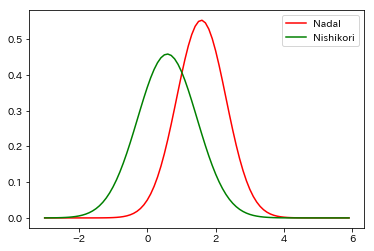

In [75]:
#錦織とナダルの比較
from scipy.stats import norm
X = np.arange(-3,6,0.1)
Y = norm.pdf(X,1.580996,0.721014)
plt.plot(X,Y,color="r",label="Nadal")
Y = norm.pdf(X,0.586693,0.869935)
plt.plot(X,Y,color="g",label="Nishikori")
plt.legend()
plt.show()

In [76]:
#2018年の錦織 vs nadal
data[((data["winner_name"]=="Rafael Nadal") & (data["loser_name"]=="Kei Nishikori"))
    | ((data["winner_name"]=="Kei Nishikori") & (data["loser_name"]=="Rafael Nadal"))]

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,winner_name,winner_hand,winner_ht,winner_ioc,winner_age,winner_rank,winner_rank_points,loser_id,loser_seed,loser_entry,loser_name,loser_hand,loser_ht,loser_ioc,loser_age,loser_rank,loser_rank_points,score,best_of,round,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_id2,loser_id2
858,2018-0410,Monte Carlo Masters,Clay,64,M,20180416,300,104745,1.0,NaN,Rafael Nadal,L,185.0,ESP,31.868583,1.0,8770.0,105453,NaN,NaN,Kei Nishikori,R,178.0,JPN,28.295688,36.0,1280.0,6-3 6-2,3,F,93.0,1.0,3.0,54.0,38.0,28.0,9.0,9.0,1.0,2.0,1.0,2.0,54.0,28.0,15.0,13.0,8.0,4.0,8.0,14.0,28.0


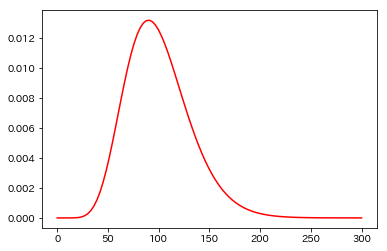

In [77]:
#ガンマ分布の確認
from scipy.stats import gamma
x = np.linspace(0,300,100)
plt.plot(x,gamma.pdf(x,a=10,scale=10),'r-',label="10-10")
#plt.plot(x,gamma.pdf(x,a=1,scale=10),'b-',label="1-10")
#plt.plot(x,gamma.pdf(x,a=10,scale=1),'g-',label="10-1")
#plt.legend()
plt.show()